## Import libraries

In [1]:
# load SMOTEd training data
import numpy as np

# VGG16 model transfer learning
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

# baseline CNN model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

# prepare final dataset 
import os
from shutil import copyfile
import shutil

# convert train images to array
import numpy as np
from numpy import asarray
from numpy import save
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

# SMOTE
from imblearn.over_sampling import SMOTE

# applying final model on make predictions on new images
from matplotlib.image import imread
from keras.models import load_model

# convert array to image
from PIL import Image as im

# rotate images
import scipy.ndimage as ndimage

In [2]:
# load train validation data
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_val = np.load('X_val.npy')
y_val = np.load('y_val.npy')

## Baseline CNN model

In [19]:
# define baseline cnn model
def define_b_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model
 
# plot diagnostic learning curves
def summarize_baseline_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = sys.argv[0].split('/')[-1]
    pyplot.savefig('baseline_learning_curve_plot.png')
    pyplot.close()

# run the test harness for evaluating a model
def run_baseline_test_harness():
    # define model
    model = define_b_model()
    # create data generator
    datagen = ImageDataGenerator(rescale=1.0/255.0)
    # prepare iterator
    # train iterator uses .flow bc it takes in the SMOTEd training set, hence cannot use flow_from_directory
    train_it = datagen.flow(X_train, y_train, batch_size=64)
    # validation iterator 
    val_it = datagen.flow(X_val, y_val, batch_size=64)
    # test iterator can use .flow_from_directory bc it was not oversampled using SMOTE
    test_it = datagen.flow_from_directory('train_test_dataset/test/', 
                                               class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it), 
                                  validation_data=val_it, validation_steps=len(val_it), epochs=20, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_baseline_diagnostics(history)

In [20]:
run_baseline_test_harness()

Found 438 images belonging to 2 classes.
> 76.941


## VGG16 CNN model transfer learning

In [2]:
# define cnn model
def define_model():
    # load model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [3]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    pyplot.savefig('learning_curve_.py_plot.png')
    pyplot.close()

### V1: With data augmentation, mean reduction using training set, train-valid-test set

In [5]:
def run_test_harness_5():
    # define model
    model = define_model()
    
    # create data generator for train set + perform data augmentation
    train_datagen = ImageDataGenerator(featurewise_center=True, width_shift_range=0.1, 
                                       height_shift_range=0.1, horizontal_flip=True)
    # specify imagenet mean values for featurewise centering
    train_datagen.fit(X_train)
    
    # create data generator for validation set
    val_datagen = ImageDataGenerator(featurewise_center=True)
    val_datagen.mean = train_datagen.mean
    
    # create data generator for test set and specify imagenet mean values for centering
    test_datagen = ImageDataGenerator(featurewise_center=True)
    test_datagen.mean = train_datagen.mean
    
    # prepare iterator
    # train iterator uses .flow bc it takes in the SMOTEd training set, hence cannot use flow_from_directory
    train_it = train_datagen.flow(X_train, y_train, batch_size=64)
    # validation iterator 
    val_it = val_datagen.flow(X_val, y_val, batch_size=64)
    # test iterator can use .flow_from_directory bc it was not oversampled using SMOTE
    test_it = test_datagen.flow_from_directory('train_test_dataset/test/', 
                                               class_mode='binary', batch_size=64, target_size=(224, 224))
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=val_it, validation_steps=len(val_it), epochs=11, verbose=1)
    
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)

In [6]:
# 11 epochs
run_test_harness_5()

C:\Users\LeeX\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 438 images belonging to 2 classes.


C:\Users\LeeX\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/11
30/30 [==============================] - 670s 22s/step - loss: 1.2773 - accuracy: 0.7609 - val_loss: 0.5095 - val_accuracy: 0.7842
Epoch 2/11
30/30 [==============================] - 669s 23s/step - loss: 0.3579 - accuracy: 0.8345 - val_loss: 0.3853 - val_accuracy: 0.8511
Epoch 3/11
30/30 [==============================] - 672s 23s/step - loss: 0.2732 - accuracy: 0.8791 - val_loss: 0.3694 - val_accuracy: 0.8541
Epoch 4/11
30/30 [==============================] - 693s 23s/step - loss: 0.2429 - accuracy: 0.8984 - val_loss: 0.3481 - val_accuracy: 0.8845
Epoch 5/11
30/30 [==============================] - 696s 23s/step - loss: 0.1870 - accuracy: 0.9103 - val_loss: 0.3480 - val_accuracy: 0.9058
Epoch 6/11
30/30 [==============================] - 685s 23s/step - loss: 0.1569 - accuracy: 0.9371 - val_loss: 0.3655 - val_accuracy: 0.8936
Epoch 7/11
30/30 [==============================] - 672s 23s/step - loss: 0.1631 - accuracy: 0.9344 - val_loss: 0.3596 - val_accuracy: 0.9149
Epoch 

C:\Users\LeeX\Anaconda3\lib\site-packages\keras\engine\training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


> 86.758


### V2: Without data augmentation, mean reduction using training set, train-valid-test set

In [9]:
def run_test_harness_7():
    # define model
    model = define_model()
    
    # create data generator for train set + perform data augmentation
    train_datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for featurewise centering
    train_datagen.fit(X_train)
    
    # create data generator for validation set
    val_datagen = ImageDataGenerator(featurewise_center=True)
    val_datagen.mean = train_datagen.mean
    
    # create data generator for test set and specify imagenet mean values for centering
    test_datagen = ImageDataGenerator(featurewise_center=True)
    test_datagen.mean = train_datagen.mean
    
    # prepare iterator
    # train iterator uses .flow bc it takes in the SMOTEd training set, hence cannot use flow_from_directory
    train_it = train_datagen.flow(X_train, y_train, batch_size=64)
    # validation iterator 
    val_it = val_datagen.flow(X_val, y_val, batch_size=64)
    # test iterator can use .flow_from_directory bc it was not oversampled using SMOTE
    test_it = test_datagen.flow_from_directory('train_test_dataset/test/', 
                                               class_mode='binary', batch_size=64, target_size=(224, 224))
    
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=val_it, validation_steps=len(val_it), epochs=11, verbose=1)
    
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=0)
    print('> %.3f' % (acc * 100.0))
    
    # learning curves
    summarize_diagnostics(history)

In [10]:
run_test_harness_7()

Found 438 images belonging to 2 classes.
Epoch 1/11
30/30 [==============================] - 830s 28s/step - loss: 1.9171 - accuracy: 0.7383 - val_loss: 0.3790 - val_accuracy: 0.8237
Epoch 2/11
30/30 [==============================] - 854s 29s/step - loss: 0.2412 - accuracy: 0.8850 - val_loss: 0.3598 - val_accuracy: 0.8875
Epoch 3/11
30/30 [==============================] - 778s 26s/step - loss: 0.1231 - accuracy: 0.9570 - val_loss: 0.3995 - val_accuracy: 0.8693
Epoch 4/11
30/30 [==============================] - 720s 24s/step - loss: 0.0457 - accuracy: 0.9882 - val_loss: 0.4251 - val_accuracy: 0.8936
Epoch 5/11
30/30 [==============================] - 680s 23s/step - loss: 0.0145 - accuracy: 0.9973 - val_loss: 0.4618 - val_accuracy: 0.8906
Epoch 6/11
30/30 [==============================] - 683s 23s/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.5040 - val_accuracy: 0.8845
Epoch 7/11
30/30 [==============================] - 696s 23s/step - loss: 0.0036 - accuracy: 1.0000 - val_l

## Using VGG-16 transfer learning as final model 

In [23]:
# preparing final dataset: final model is fit on all avail data, i.e. combination of train, validation, test sets
# step 1: create new folder called "final_dataset" with subfolders "bad" & "good"
final_dataset = 'final_dataset/'
labeldirs = ['bad/','good/']
for label in labeldirs:
    newdir = final_dataset + label
    os.makedirs(newdir, exist_ok=True)
# step 2: copy images from "train_test_dataset" folder to "final_dataset"
source = 'train_test_dataset/'
source_subdirs = os.listdir(source) # ['test', 'train']
for subdir in source_subdirs: # loop through test and train folders
    subdir_path = source + subdir + '/' # eg. train_test_dataset/test/
    subdir_list = os.listdir(subdir_path) # ['bad', 'good']
    for sub in subdir_list: # loop through bad and good folders
        final_src = subdir_path + sub + '/' # train_test_dataset/test/bad/
        for file in os.listdir(final_src): # loop through each file in the folder
            src = final_src + file # eg. train_test_dataset/test/bad/file
            dst = final_dataset + sub + '/' + file # eg. final_dataset/bad/file
            copyfile(src,dst)

In [6]:
# convert ALL images to numpy array

images, labels = list(), list()
final_dir = 'final_dataset/'  
final_subdirs = os.listdir(final_dir) # ['bad', 'good']
for subdir in final_subdirs:
    # determine class, 0 is bad, 1 is good
    output=0
    if subdir == 'good':
        output=1
    # enumerate images in each subdir
    for file in os.listdir(final_dir + subdir):
        # load image
        image = load_img(final_dir + subdir + '/' + file, target_size=(224,224))
        # convert to numpy array
        image = img_to_array(image)
        # store
        images.append(image)
        labels.append(output)
X = np.array(images)
y = np.array(labels)

# check shape and class count before SMOTE

print(X.shape)
print(np.bincount(y))

#need to reshape X from shape (a,b,c,d) into (a,b) for SMOTE
X = X.reshape(2248, 224*224*3)

# executing SMOTE; res stands for resampled - to denote training dataset balanced by SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

# check shape and class count after SMOTE
# note that the class count is now balanced; this means SMOTE oversampling is successful
print(X.shape)
print(np.bincount(y))

#reshape back from (a,b) to (a,b,c,d)
X = X.reshape(2696, 224, 224, 3)

# save data
np.save('X.npy', X)
np.save('y.npy', y)

(2248, 224, 224, 3)
[1348  900]
(2696, 150528)
[1348 1348]


In [4]:
# load final data
X = np.load('X.npy')
y = np.load('y.npy')

In [25]:
# convert smoted X,y numpy arrays to images bc using .flow causes python to crash, hence need to use .flow_from_directory

if os.path.isdir('final_dataset/good'):
    shutil.rmtree('final_dataset/good')
os.makedirs('final_dataset/good/', exist_ok=True)
count = 0
for i in range(1348,len(y)): # where output is 1
    img_array = X[i]
    #img = im.fromarray((img_array*255).astype(np.uint8))
    img = im.fromarray(img_array.astype(np.uint8))
    img.save('final_dataset/good/' + 'good_' + str(count) + '.jpg' )
    count+=1

In [5]:
# step 3: save final model for trf learning
def run_final_test_harness():
    # define model
    model = define_model()
    
    # create data generator for train set 
    train_datagen = ImageDataGenerator(featurewise_center=True)
    # specify imagenet mean values for featurewise centering
    train_datagen.fit(X)
    
    # prepare iterator
    # using .flow causes python to crash, hence need to use .flow_from_directory
    train_it = train_datagen.flow_from_directory('final_dataset/', class_mode='binary', batch_size=64, target_size = (224,224))
    
    # fit model
    model.fit_generator(train_it, steps_per_epoch=len(train_it), epochs=10, verbose=0)
    
    # save model
    model.save('final_model.h5')

In [6]:
run_final_test_harness()

C:\Users\LeeX\Anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Found 2696 images belonging to 2 classes.


C:\Users\LeeX\Anaconda3\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


## Making predictions with VGG16 final model

In [13]:
# get mean of image dataset for mean subtraction, aka centering
filepaths = ['final_dataset/good/', 'final_dataset/bad/']

R_channel = 0
G_channel = 0
B_channel = 0
num = 0
for path in filepaths:
    pathdir = os.listdir(path)
    for i in range(len(pathdir)):
        filename = pathdir[i]
        img = load_img(os.path.join(path, filename), target_size=(224,224))
        img = img_to_array(img)
        R_channel = R_channel + np.sum(img[:,:,0])
        G_channel = G_channel + np.sum(img[:,:,1])
        B_channel = B_channel + np.sum(img[:,:,2])
    num += len(pathdir)
num = num*224*224
R_mean = R_channel / num
G_mean = G_channel / num
B_mean = B_channel / num
print(R_mean,G_mean,B_mean)

163.67823808413968 153.02586058054877 139.732099973967


In [2]:
# load and prepare the image to test the model on
R_mean = 163.67823808413968
G_mean = 153.02586058054877
B_mean = 139.732099973967
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    # convert to array
    img = img_to_array(img)
    # reshape into a single sample with 3 channels
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img - [R_mean, G_mean, B_mean]
    return img

In [3]:
# apply model to make prediction for image
def example(x):
    img = load_image('demonstration_images/'+x)
    model = load_model('final_model.h5')
    result = model(img).numpy()
    print(result)

## Making predictions on new images

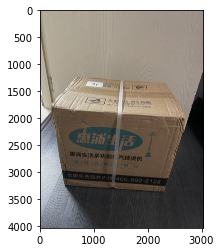

In [16]:
image1 = imread('demonstration_images/IMG_7014.jpg')
angle = 270 # in degrees
image1 = ndimage.rotate(image1, angle, reshape=True)
pyplot.imshow(image1)
pyplot.show()

In [19]:
example('IMG_7014.jpg')

[[0.00890374]]


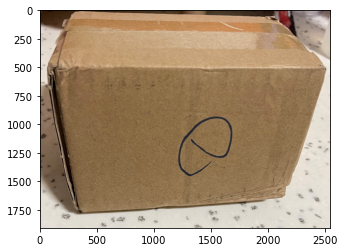

In [11]:
image2 = imread('demonstration_images/IMG_7015.jpg')
pyplot.imshow(image2)
pyplot.show()

In [20]:
example('IMG_7015.jpg')

[[0.01629695]]


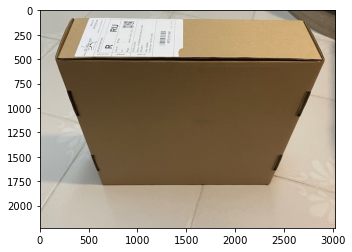

In [12]:
image3 = imread('demonstration_images/IMG_7016.jpg')
pyplot.imshow(image3)
pyplot.show()

In [21]:
example('IMG_7016.jpg')

[[0.5450768]]


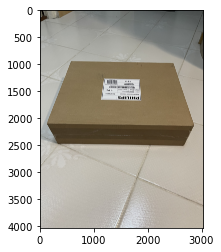

In [18]:
image4 = imread('demonstration_images/IMG_7017.jpg')
angle = 270 # in degrees
image4 = ndimage.rotate(image4, angle, reshape=True)
pyplot.imshow(image4)
pyplot.show()

In [22]:
example('IMG_7017.jpg')

[[0.964874]]


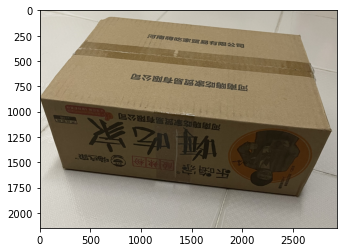

In [14]:
image5 = imread('demonstration_images/IMG_7019.jpg')
pyplot.imshow(image5)
pyplot.show()

In [23]:
example('IMG_7019.jpg')

[[0.86966574]]


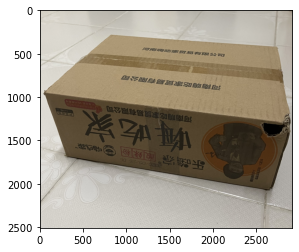

In [15]:
image6 = imread('demonstration_images/IMG_7018.jpg')
pyplot.imshow(image6)
pyplot.show()

In [24]:
example('IMG_7018.jpg')

[[0.3736746]]
